# Terrain Navigation
### Yichao Li and Wenshuo Wang

Terrain navigation is a problem with many applications. In a typical terrain navigation problem, an airplane is flying over terrain with known structure and it uses the elevation to estimate its current position.

We take the model and data (a topographical map of a Colorado region) from \citet{givens2013computational}. Let ${X}^{(t)}\in \mathbb{R}^2$ be the true location of the plane at time $t$, $h(z)$  be the true elevation at location $z$, $Y^{(t)}$ be the observed elevation at time $t$, $d^{(t)}$ be the measured shift by the inertial navigation system. Let $X^{(0)}$ be known, and the hidden Markov model is defined through
\begin{equation*}
\begin{aligned}
X^{(t)}&=X^{(t-1)}+d^{(t)}+\epsilon^{(t)},\\
X^{(t)}&=h(X^{(t)})+\delta^{(t)},
\end{aligned}
\end{equation*}
where $\mathbf{\epsilon}^{(t)}$ and $\delta^{(t)}$ are independent Gaussian error processes representing the error in drift and elevation measurement, respectively. We are interested in $\pi_t(X^{(t)}\mid Y^{(1:t)})$.

In [1]:
# Set parameters
# See Appendix B.1 for the definition of following parameters.
delta = 40
q = 200
k = 1/2
n_particles = 100
%run -i terrain_navigation.py

In [2]:
# Simulate true trajectory
random.RandomState(2020)
random.seed(2020)
x0 = 0
y0 = 30000
f = interpolate.interp2d(x = data_lat, y = data_lon, z= data_elev)
z0 = f(x0, y0)[0]

xt = x0
yt = y0
track_x = [x0]
track_y = [y0]
zt = [f(x0, y0)[0]]
for i in range(ntimes):
    Rt = np.matrix([[-xt, yt], [-yt, -xt]])/np.sqrt((xt**2 + yt**2))
    Zt = random.multivariate_normal(np.zeros(2), q**2*np.matrix([[1, 0], [0, k**2]]))
    Et = np.array(Rt.T)@Zt
    xt = xt + np.array(drift_x[i]) + Et[0]
    yt = yt + np.array(drift_y[i]) + Et[1]
    track_x.append(xt)
    track_y.append(yt)
    zt.append(f(xt, yt)[0]+ norm.rvs(scale = delta))

In [3]:
# Estimate trajectory; method can be 'multionimal', 'residual' or 'ordered_stratified'
start1 = timeit.default_timer()
track_sr = Tracking(zt, n_particles = n_particles, q= q, method = 'ordered_stratified')
time_hc = timeit.default_timer() - start1
print("Hilbert curve resampling with i.i.d. multiple-descendant growth was completed in "+ str(time_hc) +" seconds.")
start2 = timeit.default_timer()
track_sr2 = Tracking(zt, n_particles = n_particles, q= q, method = 'ordered_stratified', prop = Hilbert_Stratified_Proposal)
time_hc2 = timeit.default_timer() - start2
print("Hilbert curve resampling with stratified multiple-descendant growth was completed in "+ str(time_hc2) +" seconds.")

Hilbert curve resampling with i.i.d. multiple-descendant growth was completed in 40.403952322 seconds.
Hilbert curve resampling with stratified multiple-descendant growth was completed in 48.463277033999994 seconds.


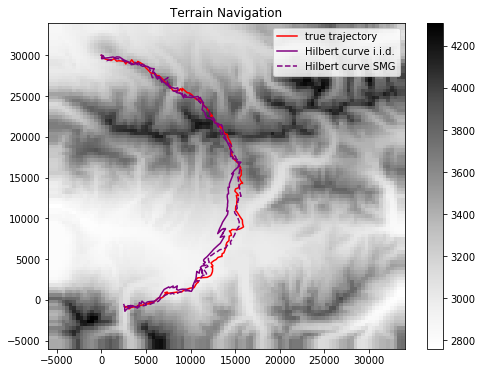

In [4]:
XI = np.linspace(-6000, 34000, 100)
YI = np.linspace(-6000, 34000, 100)
ZI = f(XI, YI)
plt.figure(figsize=(8,6))
plt.pcolor(XI, YI, ZI, cmap=cm.Greys)
plt.title('Terrain Navigation')
plt.xlim(-6000, 34000)
plt.ylim(-6000, 34000)
plt.colorbar()
plt.plot(track_x, track_y, color = 'red',label="true trajectory")
plt.plot(track_sr[0], track_sr[1], color = 'purple', label="Hilbert curve i.i.d.")
plt.plot(track_sr2[0], track_sr2[1], '--', color = 'purple', label="Hilbert curve SMG")
plt.legend(loc="upper right")
plt.show()

In [5]:
track_oracle = np.array([track_x, track_y])
def MSE(track):
    return np.mean([((track[0][i] - track_oracle[0][i])**2 + (track[1][i] - track_oracle[1][i])**2) for i in range(ntimes)])
err_sr = MSE(track_sr)
err_sr2 = MSE(track_sr2)
print("Hilbert curve i.i.d. multiple-descendant log(MSE): "+str(np.log(err_sr)))
print("Hilbert curve stratified multiple-descendant log(MSE): "+str(np.log(err_sr2)))

Hilbert curve i.i.d. multiple-descendant log(MSE): 13.665830508384019
Hilbert curve stratified multiple-descendant log(MSE): 12.848633228393973
